### Text Selection Data Prepare

In [2]:
import os
import multiprocessing
#import multiprocessing as mp
from multiprocessing import Process, Manager, Pool, Queue
from itertools import islice
from collections import Counter
import re
import pandas as pd
import numpy as np
import glob
import nltk
from nltk import word_tokenize
from functools import reduce
from pathlib import Path
import shutil
from kneed import KneeLocator

In [3]:
nprocs = multiprocessing.cpu_count()
print(f"Number of CPU cores: {nprocs}")

Number of CPU cores: 16


In [4]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
#lang_pair = "Intersect"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# adding native word to shared word
word_start = 0  # 0 native word start index
word_end = 45000  # 28 native word end index

# word all usage in twogram
word_use_num_min = 1  # word usage in selected twograms 
word_use_num_max = 2

# sentence check
twogram_sentence_check = False  # True, False
threegram_sentence_check = False
fourgram_sentence_check = False
fivegram_sentence_check = False
sixgram_sentence_check = False
sevengram_sentence_check = False
eightgram_sentence_check = False
ninegram_sentence_check = False
tengram_sentence_check = False


# n gram select
twogram_select_start = 0
twogram_select_end = 10000

threegram_select_start = 0
threegram_select_end = 10000

fourgram_select_start = 0
fourgram_select_end = 10000

fivegram_select_start = 0
fivegram_select_end = 10000

sixgram_select_start = 0
sixgram_select_end = 10000

sevengram_select_start = 0
sevengram_select_end = 10000

eightgram_select_start = 0
eightgram_select_end = 10000

ninegram_select_start = 0
ninegram_select_end = 10000

tengram_select_start = 0
tengram_select_end = 10000


# prefix suffix file
prefix_suffix = False  # True, False: True for adding prefix suffix word
native_word = True # True for adding native word

# adding output file extention
if prefix_suffix & native_word:
    file_ext = "5"
elif (not prefix_suffix) & native_word:
    file_ext = "6"
else:
    file_ext = "7"              
    
# 5 => for only native word with prefix suffix.
# 6 => for only native word without prefix suffix.

print(f"{file_ext}")

6


In [5]:
path = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/\
Text Selection/Data/1-Text Selection Data Prepare"

Path(path).mkdir(parents=True, exist_ok=True)

In [6]:
def strip(df):
    for i in df.columns:
        new_name = i.strip()
        df.rename(columns={f"{i}":f"{new_name}"}, inplace=True)
        df[f"{new_name}"] = df[f"{new_name}"].apply(lambda x: x.strip())
    
    return df

In [7]:
def word_in_wordgroup_simple(df, source_column, target_column, word_sample_num):

    '''word_in_wordgroup(df, "word", "twogram"):
       df is dataframe, source_column and target_column are 
       dataframe column string name. source_column convert list
       values that are in target column.
    '''
    
    df_select = df[[f"{target_column}"]].dropna()
    df_result = pd.DataFrame()
    for i in df[f"{source_column}"].dropna():
        try:
            word_in_word_cluster = df_select[df_select[f"{target_column}"].str.contains(fr"(?:\s|^){i}(?:\s|$)", na=True)].head(word_sample_num)    
        except:
            pass        
        word_in_word_cluster.insert(0,f"{source_column}",i)
        df_result = pd.concat([df_result,word_in_word_cluster], axis=0)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [8]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
987921,karneleme,5
987922,karnaya,5
987923,dörtlümüzün,5
987924,karnavalınız,5


In [9]:
df_word_select = df_word_all.iloc[word_start:word_end,]

In [10]:
# Option
if prefix_suffix:
    df_word = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()}/{lang_folder.capitalize()}_{word_end}_Word_Prefix_Suffix_Custom_Result_Manuel.xlsx")
    df_word = df_word.loc[:,["word","frequency"]]
    df_word = pd.concat([df_word,df_word_select], axis=0)
    df_word.drop_duplicates(inplace=True)    
    df_word.sort_values(by="frequency", ascending=False, inplace=True)
    df_word.reset_index(drop=True, inplace=True)
else:
    df_word = df_word_select

if native_word:
    df_word
else:
    df_word = df_word.head(0)

df_word

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
44995,hayırbu,871
44996,konferansına,871
44997,kardeşisin,871
44998,kaldırıyorsun,871


In [11]:
df_word.to_excel(f"Word_Selected_{word_end}.xlsx", index=False)

In [12]:
disable_list = ["sex","seks","seksi","sexy","sexe","seksüel","sexuell","gey","gay","lezbiyen","lesbienne","eşcinsel","mastürbasyon","masturbation","erotik","érotique", \
"bikini","penis","vagina","vajina","fetish","fetiş","fetishy","erotic","erotik","sexdom","kondom","condom","dildo","fetisj","hétérosexuel","féticher","fétiche","homosexuel"\
"ereksiyon","erectie","erection","érection","homoseksüel","prezervatif","préservatif","ass","fetisch","fetiche"]

In [13]:
word_select = df_word["word"].values.tolist()
word_select_set = set(word_select)
disable_word_set = set(disable_list)

In [14]:
word_list = list(word_select_set.difference(disable_word_set))
len(word_list)

44987

##### Ngrams Selected

In [15]:
if twogram_sentence_check:
    df_twogram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Two_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_twogram_sent.rename(columns={"two_gram":"twogram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_twogram = df_twogram_sent.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]
else:
    df_twogram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Twogram_Merge.csv")  
    df_twogram = df_twogram.loc[:,["twogram","frequency"]]
    #df_twogram_select = df_twogram.iloc[twogram_start:twogram_end,]

df_twogram = df_twogram[df_twogram["frequency"] > 5]
df_twogram

,twogram,frequency
0,bir şey,859944
1,değil mi,585879
2,ben de,377765
3,teşekkür ederim,370619
4,ne oldu,322758
...,...,...
4450187,tyrion mı,6
4450188,değişik yollarla,6
4450189,twitter eoozgan,6
4450190,twinkienin kalanını,6


In [16]:
d_list2  = df_twogram.iloc[:,0].values.tolist()

resultlist2 = []
manager = multiprocessing.Manager()
resultlist2 = manager.list()

def word_in_wordgroup(d_list2):
    mergelist = []
    try:
        word = d_list2.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist2.append(d_list2)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(word_in_wordgroup, d_list2) # string_word liste

result_list2 = list(resultlist2)
df_result2 = pd.DataFrame(result_list2, columns=[0])  # add columns parameter for empty result
df_result2 = df_result2.rename(columns = {0: "twogram"})
df_merge2 = pd.merge(df_result2, df_twogram, how="left", on="twogram")
df_merge_result2 = df_merge2.sort_values(by="frequency", ascending=False)
df_merge_result2.drop_duplicates(inplace=True)
df_merge_result2.reset_index(drop=True, inplace=True)
df_twogram_select = df_merge_result2
df_twogram_select

,twogram,frequency
0,bir şey,859944
1,değil mi,585879
2,ben de,377765
3,teşekkür ederim,370619
4,ne oldu,322758
...,...,...
2579546,itham edemedim,6
2579547,kartımı çaldı,6
2579548,olmaksızın oynanan,6
2579549,çalacak kişinin,6


In [17]:
twogram_frequency = df_twogram_select.iloc[:,1].sum()

In [18]:
df_twogram_select["ratio"] = round(((df_twogram_select.iloc[:,1]/twogram_frequency)*100),7)

In [19]:
df_twogram_select["cumul_ratio"] = np.cumsum(df_twogram_select["ratio"])

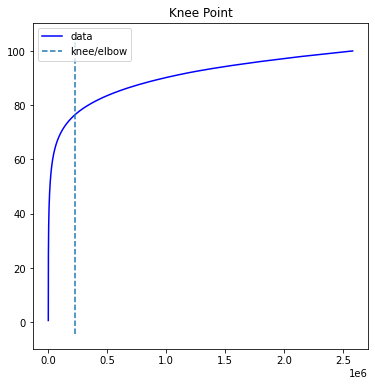

In [20]:
twogram_kneedle = KneeLocator(x=df_twogram_select.cumul_ratio.index, y=df_twogram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
twogram_kneedle.plot_knee()

In [21]:
knee_point_twogram = round(twogram_kneedle.knee_y)

In [22]:
df_twogram_knee = df_twogram_select[df_twogram_select.cumul_ratio <= knee_point_twogram]
df_twogram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_twogram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,twogram,frequency
0,bir şey,859944
1,değil mi,585879
2,ben de,377765
3,teşekkür ederim,370619
4,ne oldu,322758
...,...,...
213666,olmadan gerçek,52
213667,epey kolay,52
213668,hafızan iyi,52
213669,senin yaşındaydım,52


In [23]:
df_twogram_select2 = df_twogram_select.iloc[twogram_select_start:twogram_select_end,]
df_twogram_select2

,twogram,frequency,ratio,cumul_ratio
0,bir şey,859944,0.671225,0.671225
1,değil mi,585879,0.457305,1.128530
2,ben de,377765,0.294863,1.423392
3,teşekkür ederim,370619,0.289285,1.712677
4,ne oldu,322758,0.251927,1.964604
...,...,...,...,...
9995,baylar ve,1317,0.001028,46.599735
9996,bakalım bu,1317,0.001028,46.600763
9997,iyi olmamıştım,1317,0.001028,46.601791
9998,onu ve,1316,0.001027,46.602818


In [24]:
df_twogram_knee.to_csv("Twogram_Selected.csv", index=False)
df_twogram_select2.to_excel(f"Twogram_Selected_{twogram_select_end}.xlsx", index=False)

In [25]:
if threegram_sentence_check:
    df_threegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Three_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_threegram_sent.rename(columns={"three_gram":"threegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_threegram = df_threegram_sent.loc[:,["threegram","frequency"]]
else:
    df_threegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Threegram_Merge.csv")  
    df_threegram = df_threegram.loc[:,["threegram","frequency"]]

df_threegram

,threegram,frequency
0,bir şey yok,113165
1,bir şey var,110455
2,bu da ne,89463
3,her şey yolunda,75968
4,başka bir şey,75193
...,...,...
3009751,haydi büyük fikret,5
3009752,fikret caesardan beri,5
3009753,fikret cage kazandı,5
3009754,haydi bakayım fikret,5


In [26]:
d_list3  = df_threegram.iloc[:,0].values.tolist()

resultlist3 = []
manager = multiprocessing.Manager()
resultlist3 = manager.list()

def word_in_wordgroup(d_list3):
    mergelist = []
    try:
        word = d_list3.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist3.append(d_list3)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(word_in_wordgroup, d_list3) # string_word liste

result_list3 = list(resultlist3)
df_result3 = pd.DataFrame(result_list3, columns=[0])  # add columns parameter for empty result
df_result3 = df_result3.rename(columns = {0: "threegram"})
df_merge3 = pd.merge(df_result3, df_threegram, how="left", on="threegram")
df_merge_result3 = df_merge3.sort_values(by="frequency", ascending=False)
df_merge_result3.drop_duplicates(inplace=True)
df_merge_result3.reset_index(drop=True, inplace=True)
df_threegram_select = df_merge_result3
df_threegram_select

,threegram,frequency
0,bir şey yok,113165
1,bir şey var,110455
2,bu da ne,89463
3,her şey yolunda,75968
4,başka bir şey,75193
...,...,...
2215200,fakat otomatik pilot,10
2215201,bu günlere ben,10
2215202,ama hepsi huzurlu,10
2215203,kurtardın bir de,10


In [27]:
threegram_frequency = df_threegram_select.iloc[:,1].sum()

In [28]:
df_threegram_select["ratio"] = round(((df_threegram_select.iloc[:,1]/threegram_frequency)*100),7)

In [29]:
df_threegram_select["cumul_ratio"] = np.cumsum(df_threegram_select["ratio"])

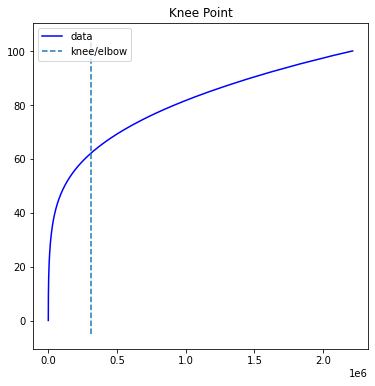

In [30]:
threegram_kneedle = KneeLocator(x=df_threegram_select.cumul_ratio.index, y=df_threegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
threegram_kneedle.plot_knee()

In [31]:
knee_point_threegram = round(threegram_kneedle.knee_y)

In [32]:
df_threegram_knee = df_threegram_select[df_threegram_select.cumul_ratio <= knee_point_threegram]
df_threegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_threegram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,threegram,frequency
0,bir şey yok,113165
1,bir şey var,110455
2,bu da ne,89463
3,her şey yolunda,75968
4,başka bir şey,75193
...,...,...
307731,arkadaş mı olmak,38
307732,olan birkaç şey,38
307733,da size anlatayım,38
307734,için olay yerine,38


In [33]:
df_threegram_select2 = df_threegram_select.iloc[threegram_select_start:threegram_select_end,]
df_threegram_select2

,threegram,frequency,ratio,cumul_ratio
0,bir şey yok,113165,0.134618,0.134618
1,bir şey var,110455,0.131395,0.266013
2,bu da ne,89463,0.106423,0.372436
3,her şey yolunda,75968,0.090370,0.462806
4,başka bir şey,75193,0.089448,0.552253
...,...,...,...,...
9995,neler oluyor be,701,0.000834,25.135250
9996,kendimi kötü hissettim,701,0.000834,25.136084
9997,biraz vaktin var,701,0.000834,25.136918
9998,bir gün müydü,701,0.000834,25.137752


In [34]:
df_threegram_knee.to_csv("Threegram_Selected.csv", index=False)
df_threegram_select2.to_excel(f"Threegram_Selected_{threegram_select_end}.xlsx", index=False)

In [35]:
if fourgram_sentence_check:
    df_fourgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Four_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fourgram_sent.rename(columns={"four_gram":"fourgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fourgram = df_fourgram_sent.loc[:,["fourgram","frequency"]]
else:
    df_fourgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fourgram_Merge.csv")  
    df_fourgram = df_fourgram.loc[:,["fourgram","frequency"]]

df_fourgram

,fourgram,frequency
0,bir şey var mı,41773
1,her şey yolunda mı,31126
2,burada ne işin var,21993
3,bir sorun mu var,21423
4,ben de seni seviyorum,17338
...,...,...
3052209,fikret miloya merhaba de,5
3052210,fikret millsin oğlu mu,5
3052211,fikret millet iyi iş,5
3052212,fikret millet bize bakıyor,5


In [36]:
d_list4  = df_fourgram.iloc[:,0].values.tolist()

resultlist4 = []
manager = multiprocessing.Manager()
resultlist4 = manager.list()

def word_in_wordgroup(d_list4):
    mergelist = []
    try:
        word = d_list4.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist4.append(d_list4)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(word_in_wordgroup, d_list4) # string_word liste

result_list4 = list(resultlist4)
df_result4 = pd.DataFrame(result_list4, columns=[0])  # add columns parameter for empty result
df_result4 = df_result4.rename(columns = {0: "fourgram"})
df_merge4 = pd.merge(df_result4, df_fourgram, how="left", on="fourgram")
df_merge_result4 = df_merge4.sort_values(by="frequency", ascending=False)
df_merge_result4.drop_duplicates(inplace=True)
df_merge_result4.reset_index(drop=True, inplace=True)
df_fourgram_select = df_merge_result4
df_fourgram_select

,fourgram,frequency
0,bir şey var mı,41773
1,her şey yolunda mı,31126
2,burada ne işin var,21993
3,bir sorun mu var,21423
4,ben de seni seviyorum,17338
...,...,...
1937931,bir üniversite kızı değilim,7
1937932,oturma yeri olmadığı halde,7
1937933,o bağı nasıl almayı,7
1937934,bir üniversite meselesi olarak,7


In [37]:
fourgram_frequency = df_fourgram_select.iloc[:,1].sum()

In [38]:
df_fourgram_select["ratio"] = round(((df_fourgram_select.iloc[:,1]/fourgram_frequency)*100),7)

In [39]:
df_fourgram_select["cumul_ratio"] = np.cumsum(df_fourgram_select["ratio"])

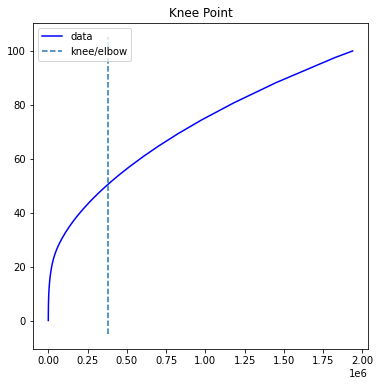

In [40]:
fourgram_kneedle = KneeLocator(x=df_fourgram_select.cumul_ratio.index, y=df_fourgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fourgram_kneedle.plot_knee()

In [41]:
knee_point_fourgram = round(fourgram_kneedle.knee_y)

In [42]:
df_fourgram_knee = df_fourgram_select[df_fourgram_select.cumul_ratio <= knee_point_fourgram]
df_fourgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fourgram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,fourgram,frequency
0,bir şey var mı,41773
1,her şey yolunda mı,31126
2,burada ne işin var,21993
3,bir sorun mu var,21423
4,ben de seni seviyorum,17338
...,...,...
388274,söz veriyorum kurul iş,16
388275,çıkmak için can atıyor,16
388276,ve içinden alevlerin çıktığı,16
388277,ne zaman isterse ama,16


In [43]:
df_fourgram_select2 = df_fourgram_select.iloc[fourgram_select_start:fourgram_select_end,]
df_fourgram_select2

,fourgram,frequency,ratio,cumul_ratio
0,bir şey var mı,41773,0.129969,0.129969
1,her şey yolunda mı,31126,0.096843,0.226812
2,burada ne işin var,21993,0.068427,0.295240
3,bir sorun mu var,21423,0.066654,0.361894
4,ben de seni seviyorum,17338,0.053944,0.415838
...,...,...,...,...
9995,bir şey mi yoksa,177,0.000551,15.477309
9996,sadece bir kez söyleyeceğim,177,0.000551,15.477859
9997,gel buraya seni küçük,177,0.000551,15.478410
9998,iyi bir insan olduğunu,177,0.000551,15.478961


In [44]:
df_fourgram_knee.to_csv("Fourgram_Selected.csv", index=False)
df_fourgram_select2.to_excel(f"Fourgram_Selected_{fourgram_select_end}.xlsx", index=False, encoding="")

In [45]:
if fivegram_sentence_check:
    df_fivegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Five_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_fivegram_sent.rename(columns={"five_gram":"fivegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_fivegram = df_fivegram_sent.loc[:,["fivegram","frequency"]]
else:
    df_fivegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Fivegram_Merge.csv")  
    df_fivegram = df_fivegram.loc[:,["fivegram","frequency"]]

df_fivegram

,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
1096831,peder fikret hep şöyle söylerdi,4
1096832,peder fikret intihar etmeye çalışıyor,4
1096833,fikret dolson 12 gün yaşadı,4
1096834,ama fikret diye biri yoktu,4


In [46]:
d_list5  = df_fivegram.iloc[:,0].values.tolist()

resultlist5 = []
manager = multiprocessing.Manager()
resultlist5 = manager.list()

def word_in_wordgroup(d_list5):
    mergelist = []
    try:
        word = d_list5.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist5.append(d_list5)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(word_in_wordgroup, d_list5) # string_word liste

result_list5 = list(resultlist5)
df_result5 = pd.DataFrame(result_list5, columns=[0])  # add columns parameter for empty result
df_result5 = df_result5.rename(columns = {0: "fivegram"})
df_merge5 = pd.merge(df_result5, df_fivegram, how="left", on="fivegram")
df_merge_result5 = df_merge5.sort_values(by="frequency", ascending=False)
df_merge_result5.drop_duplicates(inplace=True)
df_merge_result5.reset_index(drop=True, inplace=True)
df_fivegram_select = df_merge_result5
df_fivegram_select

,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
597091,uzanıp içinden cüzdanımı bulmanı istiyorum,10
597092,bir şey mi dedin anne,10
597093,seninle yarın görüşürüz tamam mı,10
597094,toplandı ve hepsi de kanla,10


In [47]:
fivegram_frequency = df_fivegram_select.iloc[:,1].sum()

In [48]:
df_fivegram_select["ratio"] = round(((df_fivegram_select.iloc[:,1]/fivegram_frequency)*100),7)

In [49]:
df_fivegram_select["cumul_ratio"] = np.cumsum(df_fivegram_select["ratio"])

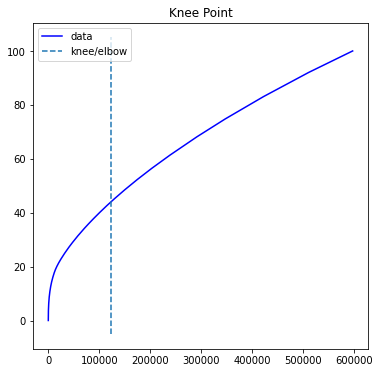

In [50]:
fivegram_kneedle = KneeLocator(x=df_fivegram_select.cumul_ratio.index, y=df_fivegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
fivegram_kneedle.plot_knee()

In [51]:
knee_point_fivegram = round(fivegram_kneedle.knee_y)

In [52]:
df_fivegram_knee = df_fivegram_select[df_fivegram_select.cumul_ratio <= knee_point_fivegram]
df_fivegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_fivegram_knee

/home/kurubal/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,fivegram,frequency
0,başka bir şey var mı,14104
1,bu da ne demek oluyor,10205
2,o kadar da kötü değil,7012
3,sence de öyle değil mi,6305
4,sana bir şey sorabilir miyim,6224
...,...,...
122369,ile matrix arasında seçim yapmam,19
122370,hey o iyi bir adam,19
122371,beklemek için nasıl bir yer,19
122372,yani bak normalde beni bilirsin,19


In [53]:
df_fivegram_select2 = df_fivegram_select.iloc[fivegram_select_start:fivegram_select_end,]
df_fivegram_select2

,fivegram,frequency,ratio,cumul_ratio
0,başka bir şey var mı,14104,0.130247,0.130247
1,bu da ne demek oluyor,10205,0.094241,0.224487
2,o kadar da kötü değil,7012,0.064754,0.289241
3,sence de öyle değil mi,6305,0.058225,0.347467
4,sana bir şey sorabilir miyim,6224,0.057477,0.404944
...,...,...,...,...
9995,daha önce hiç karşılaştık mı,66,0.000610,16.841088
9996,size yardım etmekten zevk duyarım,66,0.000610,16.841697
9997,o yüzden bir kez daha,66,0.000610,16.842307
9998,sihirli gücü gerçek bir mucize,66,0.000610,16.842916


In [54]:
df_fivegram_knee.to_csv("Fivegram_Selected.csv", index=False)
df_fivegram_select2.to_excel(f"Fivegram_Selected_{fivegram_select_end}.xlsx", index=False)

In [ ]:
if sixgram_sentence_check:
    df_sixgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Six_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sixgram_sent.rename(columns={"six_gram":"sixgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sixgram = df_sixgram_sent.loc[:,["sixgram","frequency"]]
else:
    df_sixgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sixgram_Merge.csv")  
    df_sixgram = df_sixgram.loc[:,["sixgram","frequency"]]

df_sixgram = df_sixgram[df_sixgram["frequency"] > 5]
df_sixgram

In [ ]:
d_list6  = df_sixgram.iloc[:,0].values.tolist()

resultlist6 = []
manager = multiprocessing.Manager()
resultlist6 = manager.list()

def wordgroup_with_words(d_list6):
    mergelist = []
    try:
        word = d_list6.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist6.append(d_list6)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list6) # string_word liste

result_list6 = list(resultlist6)
df_result6 = pd.DataFrame(result_list6, columns=[0])  # add columns parameter for empty result
df_result6 = df_result6.rename(columns = {0: "sixgram"})
df_merge6 = pd.merge(df_result6, df_sixgram, how="left", on="sixgram")
df_merge_result6 = df_merge6.sort_values(by="frequency", ascending=False)
df_merge_result6.drop_duplicates(inplace=True)
df_merge_result6.reset_index(drop=True, inplace=True)
df_sixgram_select = df_merge_result6
df_sixgram_select

In [ ]:
sixgram_frequency = df_sixgram_select.iloc[:,1].sum()

In [ ]:
df_sixgram_select["ratio"] = round(((df_sixgram_select.iloc[:,1]/sixgram_frequency)*100),7)

In [ ]:
df_sixgram_select["cumul_ratio"] = np.cumsum(df_sixgram_select["ratio"])

In [ ]:
sixgram_kneedle = KneeLocator(x=df_sixgram_select.cumul_ratio.index, y=df_sixgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sixgram_kneedle.plot_knee()

In [ ]:
knee_point_sixgram = round(sixgram_kneedle.knee_y)

In [ ]:
df_sixgram_knee = df_sixgram_select[df_sixgram_select.cumul_ratio <= knee_point_sixgram]
df_sixgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sixgram_knee

In [ ]:
df_sixgram_select2 = df_sixgram_select.iloc[sixgram_select_start:sixgram_select_end,]
df_sixgram_select2

In [ ]:
df_sixgram_knee.to_csv("Sixgram_Selected.csv", index=False)
df_sixgram_select2.to_excel(f"Sixgram_Selected_{sixgram_select_end}.xlsx", index=False)

In [ ]:
if sevengram_sentence_check:
    df_sevengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Seven_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_sevengram_sent.rename(columns={"seven_gram":"sevengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_sevengram = df_sevengram_sent.loc[:,["sevengram","frequency"]]
else:
    df_sevengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Sevengram_Merge.csv")  
    df_sevengram = df_sevengram.loc[:,["sevengram","frequency"]]

df_sevengram = df_sevengram[df_sevengram["frequency"] > 5]
df_sevengram

In [ ]:
d_list7  = df_sevengram.iloc[:,0].values.tolist()

resultlist7 = []
manager = multiprocessing.Manager()
resultlist7 = manager.list()

def wordgroup_with_words(d_list7):
    mergelist = []
    try:
        word = d_list7.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist7.append(d_list7)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list7) # string_word liste

result_list7 = list(resultlist7)
df_result7 = pd.DataFrame(result_list7, columns=[0])  # add columns parameter for empty result
df_result7 = df_result7.rename(columns = {0: "sevengram"})
df_merge7 = pd.merge(df_result7, df_sevengram, how="left", on="sevengram")
df_merge_result7 = df_merge7.sort_values(by="frequency", ascending=False)
df_merge_result7.drop_duplicates(inplace=True)
df_merge_result7.reset_index(drop=True, inplace=True)
df_sevengram_select = df_merge_result7
df_sevengram_select

In [ ]:
sevengram_frequency = df_sevengram_select.iloc[:,1].sum()

In [ ]:
df_sevengram_select["ratio"] = round(((df_sevengram_select.iloc[:,1]/sevengram_frequency)*100),7)

In [ ]:
df_sevengram_select["cumul_ratio"] = np.cumsum(df_sevengram_select["ratio"])

In [ ]:
sevengram_kneedle = KneeLocator(x=df_sevengram_select.cumul_ratio.index, y=df_sevengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
sevengram_kneedle.plot_knee()

In [ ]:
knee_point_sevengram = round(sevengram_kneedle.knee_y)

In [ ]:
df_sevengram_knee = df_sevengram_select[df_sevengram_select.cumul_ratio <= knee_point_sevengram]
df_sevengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_sevengram_knee

In [ ]:
df_sevengram_select2 = df_sevengram_select.iloc[sevengram_select_start:sevengram_select_end,]
df_sevengram_select2

In [ ]:
df_sevengram_knee.to_csv("Sevengram_Selected.csv", index=False)
df_sevengram_select2.to_excel(f"Sevengram_Selected_{sevengram_select_end}.xlsx", index=False)

In [ ]:
if eightgram_sentence_check:
    df_eightgram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Eight_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_eightgram_sent.rename(columns={"eight_gram":"eightgram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_eightgram = df_eightgram_sent.loc[:,["eightgram","frequency"]]
else:
    df_eightgram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Eightgram_Merge.csv")  
    df_eightgram = df_eightgram.loc[:,["eightgram","frequency"]]

df_eightgram = df_eightgram[df_eightgram["frequency"] >= 5]
df_eightgram

In [ ]:
d_list8  = df_eightgram.iloc[:,0].values.tolist()

resultlist8 = []
manager = multiprocessing.Manager()
resultlist8 = manager.list()

def wordgroup_with_words(d_list8):
    mergelist = []
    try:
        word = d_list8.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist8.append(d_list8)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list8) # string_word liste

result_list8 = list(resultlist8)
df_result8 = pd.DataFrame(result_list8, columns=[0])  # add columns parameter for empty result
df_result8 = df_result8.rename(columns = {0: "eightgram"})
df_merge8 = pd.merge(df_result8, df_eightgram, how="left", on="eightgram")
df_merge_result8 = df_merge8.sort_values(by="frequency", ascending=False)
df_merge_result8.drop_duplicates(inplace=True)
df_merge_result8.reset_index(drop=True, inplace=True)
df_eightgram_select = df_merge_result8
df_eightgram_select

In [ ]:
eightgram_frequency = df_eightgram_select.iloc[:,1].sum()

In [ ]:
df_eightgram_select["ratio"] = round(((df_eightgram_select.iloc[:,1]/eightgram_frequency)*100),7)

In [ ]:
df_eightgram_select["cumul_ratio"] = np.cumsum(df_eightgram_select["ratio"])

In [ ]:
eightgram_kneedle = KneeLocator(x=df_eightgram_select.cumul_ratio.index, y=df_eightgram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
eightgram_kneedle.plot_knee()

In [ ]:
knee_point_eightgram = round(eightgram_kneedle.knee_y)

In [ ]:
df_eightgram_knee = df_eightgram_select[df_eightgram_select.cumul_ratio <= knee_point_eightgram]
df_eightgram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_eightgram_knee

In [ ]:
df_eightgram_select2 = df_eightgram_select.iloc[eightgram_select_start:eightgram_select_end,]
df_eightgram_select2

In [ ]:
df_eightgram_knee.to_csv("Eightgram_Selected.csv", index=False)
df_eightgram_select2.to_excel(f"Eightgram_Selected_{eightgram_select_end}.xlsx", index=False)

In [ ]:
if ninegram_sentence_check:
    df_ninegram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Nine_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_ninegram_sent.rename(columns={"nine_gram":"ninegram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_ninegram = df_ninegram_sent.loc[:,["ninegram","frequency"]]
else:
    df_ninegram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Ninegram_Merge.csv")  
    df_ninegram = df_ninegram.loc[:,["ninegram","frequency"]]

df_ninegram = df_ninegram[df_ninegram["frequency"] >= 5]
df_ninegram

In [ ]:
d_list9  = df_ninegram.iloc[:,0].values.tolist()

resultlist9 = []
manager = multiprocessing.Manager()
resultlist9 = manager.list()

def wordgroup_with_words(d_list9):
    mergelist = []
    try:
        word = d_list9.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist9.append(d_list9)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list9) # string_word liste

result_list9 = list(resultlist9)
df_result9 = pd.DataFrame(result_list9, columns=[0])  # add columns parameter for empty result
df_result9 = df_result9.rename(columns = {0: "ninegram"})
df_merge9 = pd.merge(df_result9, df_ninegram, how="left", on="ninegram")
df_merge_result9 = df_merge9.sort_values(by="frequency", ascending=False)
df_merge_result9.drop_duplicates(inplace=True)
df_merge_result9.reset_index(drop=True, inplace=True)
df_ninegram_select = df_merge_result9
df_ninegram_select

In [ ]:
ninegram_frequency = df_ninegram_select.iloc[:,1].sum()

In [ ]:
df_ninegram_select["ratio"] = round(((df_ninegram_select.iloc[:,1]/ninegram_frequency)*100),7)

In [ ]:
df_ninegram_select["cumul_ratio"] = np.cumsum(df_ninegram_select["ratio"])

In [ ]:
ninegram_kneedle = KneeLocator(x=df_ninegram_select.cumul_ratio.index, y=df_ninegram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
ninegram_kneedle.plot_knee()

In [ ]:
knee_point_ninegram = round(ninegram_kneedle.knee_y)

In [ ]:
df_ninegram_knee = df_ninegram_select[df_ninegram_select.cumul_ratio <= knee_point_ninegram]
df_ninegram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_ninegram_knee

In [ ]:
df_ninegram_select2 = df_ninegram_select.iloc[ninegram_select_start:ninegram_select_end,]
df_ninegram_select2

In [ ]:
df_ninegram_knee.to_csv("Ninegram_Selected.csv", index=False)
df_ninegram_select2.to_excel(f"Ninegram_Selected_{ninegram_select_end}.xlsx", index=False)

In [ ]:
if tengram_sentence_check:
    df_tengram_sent = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/N Gram And Sentence/Ten_Gram_And_Sentence.csv")  # ext. sentence and ngram
    df_tengram_sent.rename(columns={"ten_gram":"tengram"}, inplace=True)  # ext. Not: Two_Gram_And_Sentence.csv convert to Two_Gram_And_Sentence_All.csv
    df_tengram = df_tengram_sent.loc[:,["tengram","frequency"]]
else:
    df_tengram = pd.read_csv(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.capitalize()}/Result/N Gram/Merge/Tengram_Merge.csv")  
    df_tengram = df_tengram.loc[:,["tengram","frequency"]]

#df_tengram = df_tengram[df_ninegram["frequency"] > 5]
df_tengram

In [ ]:
d_list10  = df_tengram.iloc[:,0].values.tolist()

resultlist10 = []
manager = multiprocessing.Manager()
resultlist10 = manager.list()

def wordgroup_with_words(d_list10):
    mergelist = []
    try:
        word = d_list10.split()
    except:
        word = []
        #pass  disabled for non split value
    var1 = range(len(word))
    for j in var1:
        if word[j] in word_list:
            mergelist.append(word[j])
            if len(mergelist) == len(word):
                    resultlist10.append(d_list10)
                        
if __name__ == '__main__':
    # with Pool(16) as p:
    with Pool(nprocs) as p: # Pool number CPU sayısına eşit olursa tüm CPU lar çalışır
        p.map(wordgroup_with_words, d_list10) # string_word liste

result_list10 = list(resultlist10)
df_result10 = pd.DataFrame(result_list10, columns=[0])  # add columns parameter for empty result
df_result10 = df_result10.rename(columns = {0: "tengram"})
df_merge10 = pd.merge(df_result10, df_tengram, how="left", on="tengram")
df_merge_result10 = df_merge10.sort_values(by="frequency", ascending=False)
df_merge_result10.drop_duplicates(inplace=True)
df_merge_result10.reset_index(drop=True, inplace=True)
df_tengram_select = df_merge_result10
df_tengram_select

In [ ]:
tengram_frequency = df_tengram_select.iloc[:,1].sum()

In [ ]:
df_tengram_select["ratio"] = round(((df_tengram_select.iloc[:,1]/tengram_frequency)*100),7)

In [ ]:
df_tengram_select["cumul_ratio"] = np.cumsum(df_tengram_select["ratio"])

In [ ]:
tengram_kneedle = KneeLocator(x=df_tengram_select.cumul_ratio.index, y=df_tengram_select.cumul_ratio, S=1.0, curve="concave", direction="increasing")
tengram_kneedle.plot_knee()

In [ ]:
knee_point_tengram = round(tengram_kneedle.knee_y)

In [ ]:
df_tengram_knee = df_tengram_select[df_tengram_select.cumul_ratio <= knee_point_tengram]
df_tengram_knee.drop(["ratio","cumul_ratio"], axis=1, inplace=True)
df_tengram_knee

In [ ]:
df_tengram_select2 = df_tengram_select.iloc[tengram_select_start:tengram_select_end,]
df_tengram_select2

In [ ]:
df_tengram_knee.to_csv("Tengram_Selected.csv", index=False)
df_tengram_select2.to_excel(f"Tengram_Selected_{tengram_select_end}.xlsx", index=False)

#### Copy Move And Delete

In [55]:
output_file = glob.glob(f"*_Selected*")
output_file

['Word_Selected_45000.xlsx',
 'Twogram_Selected.csv',
 'Twogram_Selected_10000.xlsx',
 'Threegram_Selected.csv',
 'Threegram_Selected_10000.xlsx',
 'Fourgram_Selected.csv',
 'Fourgram_Selected_10000.xlsx',
 'Fivegram_Selected.csv',
 'Fivegram_Selected_10000.xlsx']

In [56]:
for l in output_file:
    source = l # source directory
    destination = path
    shutil.copy2(source, destination)

In [57]:
for j in output_file:
    try:
        os.remove(j)
    except:
        pass

In [ ]:
df_ngram_concat = pd.concat([df_twogram_select, df_threegram_select, df_fourgram_select, df_fivegram_select], axis=1)
df_ngram_concat

In [ ]:
df_two_in_three = word_in_wordgroup_simple(df_ngram_concat, "twogram","threegram",threegram_sample)
df_two_in_four = word_in_wordgroup_simple(df_ngram_concat, "twogram","fourgram",fourgram_sample)
df_two_in_five = word_in_wordgroup_simple(df_ngram_concat, "twogram","fivegram",fivegram_sample)

In [ ]:
df_twogram_order_join_threegram = df_two_in_three.groupby(["twogram"])["threegram"].apply(", ".join).reset_index()
df_twogram_order_join_fourgram = df_two_in_four.groupby(["twogram"])["fourgram"].apply(", ".join).reset_index()
df_twogram_order_join_fivegram = df_two_in_five.groupby(["twogram"])["fivegram"].apply(", ".join).reset_index()  

In [ ]:
dfs = [df_twogram_order_join_threegram, df_twogram_order_join_fourgram, df_twogram_order_join_fivegram]

In [ ]:
df_ngram_sample_join_merge = reduce(lambda  left,right: pd.merge(left,right, on=['twogram'], how='outer'), dfs)
df_ngram_sample_join_merge.drop_duplicates(inplace=True)
df_ngram_sample_join_merge 

In [ ]:
df_ngram_sample_join_merge = pd.merge(df_ngram_sample_join_merge, df_twogram_select, how="right", on="twogram")
df_ngram_sample_join_merge.drop_duplicates(inplace=True)
df_ngram_sample_join_merge.rename(columns={"frequency":"two_freq"}, inplace=True)
df_ngram_sample_join_merge.sort_values(by="two_freq", ascending=False, inplace=True)
df_ngram_sample_join_merge.reset_index(drop=True, inplace=True)
df_ngram_sample_join_merge

In [ ]:
df_ngram_sample_join_merge.to_excel(f"{lang_folder.capitalize()}_{len(df_twogram_select)}_Twogram_In_{threegram_sample}_Threegram_{fourgram_sample}_\
Fourgram_{fivegram_sample}_Fivegram_Sample_With_{word_end}_Word_Join_Result.xlsx", index=False)

#### Adding Frequency For Ratio

In [ ]:
df_two_in_three_freq = pd.merge(df_two_in_three, df_threegram, how="left", on="threegram")
df_two_in_three_freq.drop_duplicates(inplace=True)
df_two_in_three_freq.rename(columns={"frequency":"three_freq"}, inplace=True)
df_two_in_three_freq.drop(["twogram"], axis=1, inplace=True)
df_two_in_three_freq

In [ ]:
df_two_in_four_freq = pd.merge(df_two_in_four, df_fourgram, how="left", on="fourgram")
df_two_in_four_freq.drop_duplicates(inplace=True)
df_two_in_four_freq.rename(columns={"frequency":"four_freq"}, inplace=True)
df_two_in_four_freq.drop(["twogram"], axis=1, inplace=True)
df_two_in_four_freq

In [ ]:
df_two_in_five_freq = pd.merge(df_two_in_five, df_fivegram, how="left", on="fivegram")
df_two_in_five_freq.drop_duplicates(inplace=True)
df_two_in_five_freq.rename(columns={"frequency":"five_freq"}, inplace=True)
df_two_in_five_freq.drop(["twogram"], axis=1, inplace=True)
df_two_in_five_freq

In [ ]:
df_ngram_sample_concat = pd.concat([df_twogram_select,df_two_in_three_freq, df_two_in_four_freq, df_two_in_five_freq], axis=1)
df_ngram_sample_concat

In [ ]:
df_ngram_sample_concat.to_excel(f"{lang_folder.capitalize()}_{len(df_twogram_select)}_Twogram_In_{threegram_sample}_Threegram_{fourgram_sample}_\
Fourgram_{fivegram_sample}_Fivegram_Sample_With_{word_end}_Word_Frequency_Result.xlsx", index=False)

#### Calculate Result And Select Ratio

In [ ]:
df_ngram_threegram_unique = df_ngram_sample_concat[["threegram","three_freq"]].drop_duplicates()
df_ngram_fourgram_unique = df_ngram_sample_concat[["fourgram","four_freq"]].drop_duplicates()
df_ngram_fivegram_unique = df_ngram_sample_concat[["fivegram","five_freq"]].drop_duplicates()

In [ ]:
twogram_result_freq = df_twogram_select["frequency"].sum()
threegram_result_freq = df_ngram_threegram_unique["three_freq"].sum()
fourgram_result_freq = df_ngram_fourgram_unique["four_freq"].sum()
fivegram_result_freq = df_ngram_fivegram_unique["five_freq"].sum()

In [ ]:
twogram_select_freq = df_twogram.iloc[twogram_select_start:twogram_select_end,]["frequency"].sum()
threegram_select_freq = df_threegram.iloc[threegram_select_start:threegram_select_end,]["frequency"].sum()
fourgram_select_freq = df_fourgram.iloc[fourgram_select_start:fourgram_select_end,]["frequency"].sum()
fivegram_select_freq = df_fivegram.iloc[fivegram_select_start:fivegram_select_end,]["frequency"].sum()

In [ ]:
(twogram_result_freq/twogram_select_freq)*100

In [ ]:
(threegram_result_freq/threegram_select_freq)*100

In [ ]:
(fourgram_result_freq/fourgram_select_freq)*100

In [ ]:
(fivegram_result_freq/fivegram_select_freq)*100

#### Copy Move And Delete

In [ ]:
output_file = glob.glob(f"{lang_folder.capitalize()}_{len(df_twogram_select)}_Twogram_In_{threegram_sample}_Threegram_{fourgram_sample}_\
Fourgram_{fivegram_sample}_Fivegram_Sample_*_Result.xlsx")
output_file

In [ ]:
for k in output_file:
    source = k # source directory
    destination = path
    shutil.copy2(source, destination)

In [ ]:
for i in output_file:
    try:
        os.remove(i)
    except:
        pass

#### Temp

In [ ]:
import os
import multiprocessing
#import multiprocessing as mp
from multiprocessing import Process, Manager, Pool, Queue
from itertools import islice
from collections import Counter
import re
import pandas as pd
import numpy as np
import glob
import nltk
from nltk import word_tokenize
from functools import reduce
from pathlib import Path
import shutil

In [ ]:
nprocs = multiprocessing.cpu_count()
print(f"Number of CPU cores: {nprocs}")

In [ ]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
#lang_pair = "Intersect"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# adding native word to shared word
word_start = 0  # 0 native word start index
word_end = 200  # 28 native word end index

# word all usage in twogram
word_use_num_min = 1  # word usage in selected twograms 
word_use_num_max = 4

In [ ]:
def word_usage_result(word_list, df_target, target_column, word_usage_min, word_usage_max): # word_usage_result(word_list, df_target, target_column, target_opt_column, word_usage_min, word_usage_max)
    '''
    word_usage_result(word_list, df_ngram_pair, "threegram", "frequency", 1, 5) \n
    word_list is a list, df_target is a dateframe, target_column is df_target dataframe target column, \n
    target_opt_column is df_target dataframe opt_target column, \n
    word_usage_min and word_usage_max word usage condition.
    '''    
    word_num_dict = {}
    for i in word_list:
        word_num_dict[f"{i}"] = 0
    
    result_list_select = []
    var_list = []
    for i in range(len(df_target)):
        target_value = df_target.loc[i,f"{target_column}"]
        #opt_value = df_target.loc[i,f"{target_opt_column}"]
        words = word_tokenize(target_value)   
        temp_list = [word for word in words]
        temp_list = temp_list + var_list
        # word count for max
        dict_list_count = Counter(temp_list)
        count_list = list(dict_list_count.values())
        # word count for min
        count_list2 = list(word_num_dict.values())
    
        if any([True if i>word_usage_max else False for i in count_list]) or not(any([True if j<word_usage_min else False for j in count_list2])):
            pass
        else:
            var_list = temp_list
            result_list_select.append([target_value])
            #result_list_select.append([target_value,opt_value])  
    
            for item2 in dict_list_count.items(): 
                word_num_dict[item2[0]] = item2[1]        
    df_result = pd.DataFrame(result_list_select, columns=[f"{target_column}"])
    #df_result = pd.DataFrame(result_list_select, columns=[f"{target_column}",f"{target_opt_column}"])
    #df_result.sort_values(by="frequency", ascending=False, inplace=True)
    df_result.reset_index(drop=True, inplace=True)
    
    return df_result

In [ ]:
def word_count_result(df,column_list): # df is dataframe, column_list is list value
    '''
    word_count_bool(df, column_list): df columns word count for word frequency\n
    df is dataframe, column_list is list value\n
    word_count_bool(df, ["word","twogram"]):
    '''
    list_all = []
    for i in df.loc[:,[x for x in column_list]].columns:
        var_list = df[f"{i}"].dropna().tolist()
        for j in var_list:
            list_all.append(j)
    text = " ".join(list_all)
    word_list = re.findall(r"\w+",text, re.UNICODE)
    df_word_list = pd.DataFrame(word_list, columns=["word"])
    #df_word_list.rename(columns={0:"word"}, inplace=True)
    df_word_count = pd.DataFrame(df_word_list.value_counts())
    df_word_count.reset_index(inplace=True)
    df_word_count.rename(columns={0:"word_count"}, inplace=True)
    
    return  df_word_count

In [ ]:
def word_in_wordgroup_simple(df, source_column, target_column, word_sample_num):

    '''word_in_wordgroup(df, "word", "twogram"):
       df is dataframe, source_column and target_column are 
       dataframe column string name. source_column convert list
       values that are in target column.
    '''
    
    df_select = df[[f"{target_column}"]].dropna()
    df_result = pd.DataFrame()
    for i in df[f"{source_column}"].dropna():
        try:
            word_in_word_cluster = df_select[df_select[f"{target_column}"].str.contains(fr"(?:\s|^){i}(?:\s|$)", na=True)].head(word_sample_num)    
        except:
            pass        
        word_in_word_cluster.insert(0,f"{source_column}",i)
        df_result = pd.concat([df_result,word_in_word_cluster], axis=0)
    df_result.reset_index(drop=True, inplace=True)

    return df_result

In [ ]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

In [ ]:
df_word_select = df_word_all.iloc[word_start:word_end,]

In [ ]:
word_list = df_word_select["word"].to_list()

In [ ]:
df_two_three = pd.read_excel("/home/kurubal/Downloads/Twogram Threegram.xlsx")
df_two_three

In [ ]:
word_count_result(df_two_three,["threegram"])

In [ ]:
df_two_three["twogram"].count()

In [ ]:
df_two_three["threegram"].count()

In [ ]:
df_two_in_three = word_in_wordgroup_simple(df_two_three, "twogram","threegram",threegram_sample)
df_two_in_three

In [ ]:
set_all_twogram = set(df_two_three["twogram"].dropna().to_list())
set_twogram_in_threegram = set(df_two_in_three["twogram"].to_list())

In [ ]:
set_all_twogram.difference(set_twogram_in_threegram)

In [ ]:
set_threegram_cover_twogram = set(df_two_in_three["threegram"].to_list())
df_selected_threegram = pd.DataFrame(set_threegram_cover_twogram,columns=["threegram"])
df_selected_threegram

In [ ]:
df_selected_threegram.to_excel("Threegram_Selected.xlsx", index=False)

In [ ]:
word_count_result(df_selected_threegram,["threegram"])

In [ ]:
df_threegram_word_usage_select = word_usage_result(word_list, df_selected_threegram, "threegram", word_use_num_min, word_use_num_max)
df_threegram_word_usage_select

In [ ]:
word_count_result(df_threegram_word_usage_select,["threegram"])